# Problema de predicción de pagos de crédito

En este desafío su trabajo consiste en implementar un modelo que prediga si un crédito será pagado a tiempo o no.

1. La clase minoritaria o de interés está representada por 1 (crédito no pagado a
tiempo) y la clase mayoritaria por 0 (crédito pagado a tiempo).
2. Las métricas de evaluación que usará son Gini y F1-score.
3. El conjunto está desbalanceado.
4. Las variables discretas que fueron convertidas a columnas, se identifican con una
letra diferente (d69 y d70).
5. Si decide usar regresión logística, tenga en cuenta que para estos problemas suele
hacerse un tratamiento previo a los datos usando Weight of Evidence and Binning. Si
por el contrario usa algoritmos más complejos, tenga en cuenta que debe indicar
conceptualmente, qué haría para dar indicios de cuáles son las variables que tienen
más peso en la decisión.

Se importan algunas librerias básicas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats

## Carga de datos

Se cargan los datos tanto de entrenamiento como de test en dataframes distintos. Y se hace una visualizacion de como quedó el 
dataframe

In [2]:
# Se cargan los datos
train_df = pd.read_csv("train.csv")
train_label = np.genfromtxt("train_label.csv", delimiter=",")
test_df = pd.read_csv("test.csv")
test_label = np.genfromtxt("test_label.csv", delimiter=",")


# Debido a que la columna que no está nombrada tiene valores únicos se le considerará como un índice
# y se le pondrá el nombre de ID y se eliminará como variable
train_df = train_df.rename(columns={"Unnamed: 0": "id"})
train_df.index = train_df['id']
test_df = test_df.rename(columns={"Unnamed: 0": "id"})
test_df.index = test_df['id']

del train_df['id'], test_df['id']

In [3]:
# Se le agregan las etiquetas al dataframe
train_label_df = pd.DataFrame(train_label, columns=['label'], index=train_df.index)
train = pd.concat([train_df, train_label_df], axis=1)

test_label_df = pd.DataFrame(test_label, columns=['label'], index=test_df.index)
test = pd.concat([test_df, test_label_df], axis=1)

train.head(10)

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,ae62,ae63,ae64,ae65,ae66,ae67,ae68,d69,d70,label
id,,,,,,,,,,,,,,,,,,,,,
1651,0.00,143270.10,100.0,0.0,0.0,6.309056e+07,4199850.00,0.0,6240000.0,17.0,...,0,0,0,0,0,0,0,0,0,0.0
1370,0.00,1403461.97,90.0,10.0,29.0,8.013914e+06,8177030.69,44951.9,0.0,12.0,...,0,0,0,0,0,0,0,0,0,1.0
2649,19800.24,63401.41,100.0,0.0,0.0,3.233846e+05,67610.22,0.0,0.0,4.0,...,0,0,0,0,0,0,0,1,0,1.0
564,0.00,10585032.22,100.0,0.0,5.0,2.959668e+07,186964.54,0.0,4500000.0,11.0,...,0,0,0,0,0,0,0,0,0,0.0
2728,0.00,11259663.09,78.0,22.0,0.0,3.362660e+07,0.00,0.0,3972827.7,24.0,...,1,0,0,0,0,0,0,0,0,1.0
2696,0.00,0.00,100.0,0.0,0.0,1.000000e+06,0.00,0.0,900000.0,10.0,...,0,0,0,0,0,0,0,0,0,1.0
173,0.00,130436.41,100.0,0.0,0.0,2.355235e+08,9907068.37,0.0,0.0,29.0,...,0,0,0,0,0,0,0,0,0,1.0
1939,0.00,2714579.60,100.0,0.0,3.0,1.472134e+07,0.00,0.0,3071719.0,23.0,...,0,0,0,0,0,0,0,0,0,0.0
2512,0.00,6400113.20,100.0,0.0,5.0,3.308427e+07,0.00,0.0,0.0,24.0,...,1,0,0,0,0,0,0,0,0,0.0


## Observaciones

En esta seccion se realizan algunas observaciones del conjnto de datos

In [4]:
# Se verifica que el conjunto está desbalanceado y por cuanto
raz = np.sum(train_label)/train_label.shape[0]
print(f'La razon entre casos de crédito no pagado y crédito pagado en el conjunto de entrenamiento es de: {raz:0.3f}')

La razon entre casos de crédito no pagado y crédito pagado en el conjunto de entrenamiento es de: 0.196


La variable 34 y 36 es la misma en casi todas las instancias (solo en 5 instancias son distintas), por lo que una es redundante y se elimina del dataset

In [5]:
print('Solo en ',np.sum(train['v34']!=train['v36']),' instancias las variables 34 y 36 son distintas')

train.loc[train['v34']!=train['v36'], ['label','v34','v36']]

Solo en  5  instancias las variables 34 y 36 son distintas


,label,v34,v36
id,,,
219,1.0,60.0,29.0
2509,0.0,397.0,92.0
2238,1.0,152.0,29.0
1265,1.0,123.0,31.0
1008,0.0,700.0,92.0


Las variable v21 y v22, estan directamente relacionadas con v30, $v_{21} + v_{22} = v_{30}$, por lo que una variable es redundante y se debe eliminar.

In [6]:
print('v21 + v22 = v30 para todas las instancias')
train.loc[train['v21']+train['v22']!=train['v30'], ['label','v30']]

v21 + v22 = v30 para todas las instancias


,label,v30
id,,


Las variable v16 y v29, estan relacionadas ya que la variable v29 solo toma valores de 0 ó 100. 

Cuando toma valores de 0, la variable v16 tambien es 0, mientras que cuando toma el valor 100 la variable v16 es diferente de 0.

A continuación se imprimen las unicas 11 instancias donde no sucede eso.

In [7]:
train.loc[train['v29']*train['v16']/100!=train['v16'], ['label','v16','v29']]

,label,v16,v29
id,,,
758,1.0,82.0,0.0
1833,0.0,38.0,0.0
315,0.0,2151.0,0.0
2594,0.0,381.0,0.0
1664,0.0,84.0,0.0
916,0.0,472.0,0.0
2510,0.0,381.0,0.0
1480,1.0,252.0,0.0
563,0.0,984.0,0.0


Las relaciones anteriores se obtuvieron de analizar y observar los datos tanto en gráficas, como sacando coeficientes de correlacion. 

El coeficiente de correlacion que se utilizó en este caso fue el de Spearman para obtener tanto realciones lineales como no lineales.

In [8]:
corr,pval = stats.spearmanr(train.to_numpy()[:,0:37])

# Quitar comentario para ver la matriz de correlacion
#print((np.abs(corr)>0.90)*1)
#print(corr[np.abs(corr)>0.90])

Ejemplo de visualización. Aqui se puede ver la relacion de la variable 2 con la variable 3


Text(0.5, 1.0, 'Relacion entre variables 2 y 3')

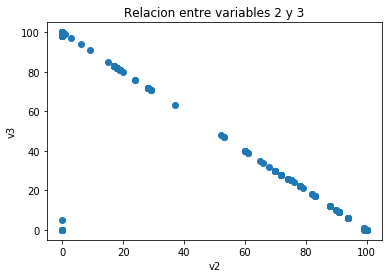

In [9]:
print('Ejemplo de visualización. Aqui se puede ver la relacion de la variable 2 con la variable 3')
plt.scatter(train['v2'],train['v3'])
plt.xlabel('v2')
plt.ylabel('v3')
plt.title('Relacion entre variables 2 y 3')

Las variables 37 en delante son 5 variables categoricas que fueron codificadaas con 'one hot'. Para comprobarlo se suma sobre cada variable con letra diferente y se comprueba que la suma no da mas de 1, es decir, las variables no tienen valores cruzados.

In [10]:
train_np = train.to_numpy()
# Las primeras 36 variables son no categóricas por lo que se acomodan en un vector distinto al de las variables categóricas
train_np_nc = train_np[:,0:37]
# El resto de la variables son categoricas y ya estan codificadas (modo one hot), por lo que no necesitan un preprocesamiento
# de estandarización
train_np_c = train_np[:,37:71]

print('Valores cruzados variable tcs :',np.sum(np.sum(train_np_c[:,0:6], axis=1)>1))
print('Valores cruzados variable tc :',np.sum(np.sum(train_np_c[:,6:17], axis=1)>1))
print('Valores cruzados variable dv :',np.sum(train_np_c[:,17]>1))
print('Valores cruzados variable ae :',np.sum(np.sum(train_np_c[:,18:32], axis=1)>1))
print('Valores cruzados variable d :',np.sum(np.sum(train_np_c[:,32:34], axis=1)>1))

Valores cruzados variable tcs : 0
Valores cruzados variable tc : 0
Valores cruzados variable dv : 0
Valores cruzados variable ae : 0
Valores cruzados variable d : 0


La variable d70 son solo ceros, por lo que no brinda informacion y se puede eliminar del dataset

In [11]:
print('Instancias de de la variable 70 diferentes de 0')
train.loc[train['d70']!=0, ['label','d70']]

Instancias de de la variable 70 diferentes de 0


,label,d70
id,,


Algunas variables categóricas tienen muy pocas instancias por lo que se pueden juntar con otras de la misma clasificacion para quitar algunas variables innecesarias.
En el siguiente código se imprime la suma total de instancias donde cada variable categórica es distinta de 0

In [12]:
# Los nombres de las variables sin contar la etiqueta
variables_keys = train.keys()[0:-1]

# Variables categoricas
key_cat = variables_keys[~pd.Series(variables_keys).str.startswith('v')]
train_c = train[key_cat]

t_c =  train_c.to_numpy()
train_label.shape
t_c.shape
print((np.sum(t_c,axis=0)))

[ 336 1389  297   71    8   46   10    6   21    1    1   24  626   36
 1431    1   28  601  452  247  287   76    9   14   76  814    9   48
   10   32   17   97  268    0]


En la siguiente funcion se realizan todas las operaciones mencionadas en esta sección para eliminar variables o datos del conjunto de datos

In [13]:
# Funcion que regresa el dataframe transformado
def transforma_data_frame(df, df_base, threshold = .991):

    # Se eliminan variable 36, 30 , 29 y 70
    df_s = df.drop(['v29','v30','v36','d70'],axis = 1)

    # Las variables categoricas se enlistan
    var_cat = np.array(['tcs37', 'tcs38', 'tcs39',
           'tcs40', 'tcs41', 'tcs42', 'tc43', 'tc44', 'tc45', 'tc46', 'tc47',
           'tc48', 'tc49', 'tc50', 'tc51', 'tc52', 'tc53', 'dv54', 'ae55', 'ae56',
           'ae57', 'ae58', 'ae59', 'ae60', 'ae61', 'ae62', 'ae63', 'ae64', 'ae65',
           'ae66', 'ae67', 'ae68', 'd69', 'label'])

    # indices de las columnas de variables categoricas que tienen muy pocas instancias
    indice = np.any([[np.sum(df_base[var_cat], axis=0)<df_base.shape[0]*(1-threshold)],
                     [np.sum(df_base[var_cat], axis=0)>df_base.shape[0]*threshold]], axis=0).reshape(-1,)


    no_tcs = pd.Series(var_cat[indice][~pd.Series(var_cat[indice]).str.startswith('tcs')]).str.startswith('tc')

    # variables eliminadas puestas en una lista
    vars_el = np.array([var_cat[indice][pd.Series(var_cat[indice]).str.startswith('tcs')],
              var_cat[indice][~pd.Series(var_cat[indice]).str.startswith('tcs')][no_tcs],
              var_cat[indice][pd.Series(var_cat[indice]).str.startswith('dv')],
              var_cat[indice][pd.Series(var_cat[indice]).str.startswith('ae')]])

    # ciclo donde se eliminan las instancias
    enu=0
    for var_el in vars_el:
        enu +=1 
        if var_el.size>0:
            # Se nombran las nuevas variables como 's'+numero
            t_df = pd.DataFrame(np.sum(df_s[var_el],axis=1),columns=['s'+str(enu)])
            df_s = pd.concat([df_s,t_df],axis = 1)

    df_s = df_s.drop(var_cat[indice],axis=1)
    
    # vuelve a poner la columna label hasta el final
    lab = pd.DataFrame(df_s['label'])
    df_s = df_s.drop(['label'],axis=1)
    df_s = pd.concat([df_s,lab],axis = 1)
    
    return df_s

In [14]:
train_new = transforma_data_frame(train, train)
train_new.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,ae61,ae62,ae64,ae66,ae68,d69,s1,s2,s4,label
id,,,,,,,,,,,,,,,,,,,,,
1651,0.00,143270.10,100.0,0.0,0.0,63090564.44,4199850.00,0.0,6240000.0,17.0,...,0,0,0,0,0,0,0,0,0,0.0
1370,0.00,1403461.97,90.0,10.0,29.0,8013913.78,8177030.69,44951.9,0.0,12.0,...,0,0,0,0,0,0,0,0,0,1.0
2649,19800.24,63401.41,100.0,0.0,0.0,323384.60,67610.22,0.0,0.0,4.0,...,1,0,0,0,0,1,0,0,0,1.0
564,0.00,10585032.22,100.0,0.0,5.0,29596681.95,186964.54,0.0,4500000.0,11.0,...,0,0,0,0,0,0,0,0,0,0.0
2728,0.00,11259663.09,78.0,22.0,0.0,33626595.71,0.00,0.0,3972827.7,24.0,...,0,1,0,0,0,0,0,0,0,1.0


## Preprocesamiento de variables
En esta seccion se hace el preprocesamiento numerico de algunas variables antes de utilizarlas en el modelo. Esto se hace para que el modelo pueda tener una mayor capacidad de predicción.

La siguiente funcion tiene el propósito de separar las variables categóricas de las no categóricas para poder realizar un preprocesamiento adecuado.

In [15]:
# Funcion para separar los datos en distintos dataframes
def separa(df):

    # Los nombres de las variables sin contar la etiqueta
    variables_keys = df.keys()[0:-1]

    # Variables no categoricas
    key_cat = variables_keys[pd.Series(variables_keys).str.startswith('v')]
    df_nc = df[key_cat]

    # Variables categoricas
    key_cat = variables_keys[~pd.Series(variables_keys).str.startswith('v')]
    df_c = df[key_cat]
    return df_nc,df_c

In [16]:
# dataset separado en variables cateóricas y no categóricas
train_nc,train_c = separa(train_new)

In [17]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

### Escalamiento de variables

Variables distintas generalmente no estan en la misma escala, algunas pueden ser muy grandes o muy pequeñas comparadas con otras. Esto puede resultar en un problema al entrenar los modelos ya que las variables a mayor escala acapararan mas la atencion del modelo debido a su magnitud, a pesar de que pueden no ser realmente significativas para la prediccion.
Para evitar esto, las variables se transforman a una misma escala y existen distintos métodos para esto. Algunas opciones son las siguientes

- Estandarización

Convierte los datos a una distribucion normal con un promedio de $\mu = 0$ y una desviacion estandar de $\sigma = 1$

- Escalamiento unitario

Escala los datos y los encapsula en valores entre 0 y 1 con la siguiente forma
$$ x_{new} = \frac{x- x_{min}}{x_{max}-x_{min}}$$

Despues de algunas iteraciones para este problema en especifico, resultó que la operación de estandarizacion tuvo un mejor rendimiento que la de escalamiento unitario por lo que se utilizará dicho algoritmo.

###  Reduccion de numero de variables utilizando PCA (opcional)

PCA (Analisis de componentes principales), es una técnica para reducir el numero de variables del problema. Al reducir el número de dimensiones del problema el tiempo de convergencia del algoritmo puede reducir drasticamente, aunque esto puede llegar a reducir la precisión del algoritmo debido a los datos que se pierden. El 'trade-off' entre precision y tiempo de convergencia del algoritmo es lo que debe tomar en cuenta el usuario al utilizar esta técnica de preprocesmiento.

En este código se utiliza un PCA con un 95%, es decir se reduce la dimensionalidad conservando un 95% de la varianza de los datos del problema original.

In [18]:
# Standardize the data
scaler = preprocessing.StandardScaler().fit(train_nc.to_numpy())
t_nc = scaler.transform(train_nc)

# Data between 0 and 1
#scaler = preprocessing.MinMaxScaler().fit(train_nc)
#t_nc = scaler.transform(train_nc)

pca = PCA(.95,svd_solver='auto').fit(t_nc)
t_nc = pca.transform(t_nc)
t_nc.shape

(2189, 26)

# Modelos

Una red neuronal multicapa (MLP-NN) de clasificacion fue utilizada para la solución de este problema

Despues de varias iteraciones con distintas configuraciones para la red neuronal se utilizó una con 3 capas escondidas, la primera con 14 nodos, la segunda con 5 nodos y la última con 2. La funcion de activacion utilizada en las capas escondidas fue la ReLU (Rectified Linear Unit). un learning rate constante con valor de 0.001.

Tambien se utilizó un random forest para clasificacion, utilizando el criterio de Gini y dandole un valor mayor a la clase minoritaria para la clasificacion.

Los modelos fueron construidos utilizando la libreria [ScikitLearn](https://scikit-learn.org/stable/index.html)

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [20]:
# Junta nuevamente los datos de entrenaiento ya que estaban separados en categoricas y no categóricas
X_train = np.concatenate((t_nc,train_c),axis=1)
print(X_train.shape)
y_train = train_label

# Realiza las transformaciones necesarias al conjunto de test
X_test = transforma_data_frame(test,train)
X_test_nc,X_test_c = separa(X_test)
X_test_nc = scaler.transform(X_test_nc)
X_test_nc = pca.transform(X_test_nc)
X_test = np.concatenate((X_test_nc,X_test_c),axis=1)
print(X_test.shape)
y_test = test_label

(2189, 51)
(548, 51)


In [21]:
RFC = RandomForestClassifier(n_estimators=250,random_state=0, criterion='gini', class_weight={0: 1,1: 8})
RFC.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 8},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [22]:
# Neural network model fitting
MLPC = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(14,5,2), max_iter=800, random_state=0)
MLPC.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(14, 5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=800, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

### Evaluacion del modelo

Para evaluar la capacidad de predicción del modelo se realiza una prueba del modelo entrenado en un conjunto de datos independiente, el cual el modelo no 'vio' al entrenarse.
Las métricas de evaluacion tanto para el modelo de red neuronal como el de random forest, se utilizaron las fórmulas de precision y exhaustividad asi como la metrica de F que es una combinacion de ambas métricas, las métricas se definen de la siguiente manera

$$Precision = \frac{vp}{vp+fp}$$


$$Exhaustividad = \frac{vp}{vp+fn}$$


$$F(\beta) = (1+\beta^2)(\frac{precision \times exhaustividad}{\beta^2 precision + exhaustividad})$$

Donde vp significa verdaderos positivos, fp falsos positivos (casos que son negativos pero fueron predichos como positivos) y fn falsos negativos (casos que eran positivos pero fueron clasificados como negativos).

In [23]:
print("MLP-NN coeficiente de determinacion en el test set:", (MLPC.score(X_test,y_test)))
print("Random forest coeficiente de determinacion en el test:", (RFC.score(X_test,y_test)))

MLP-NN coeficiente de determinacion en el test set: 0.9124087591240876
Random forest coeficiente de determinacion en el test: 0.9197080291970803


La matriz de confusion de Random Forest es para los datos en el test set: 
 [[413  27]
 [ 17  91]]
La matriz de confusion de la red neuronal es para los datos en el test set: 
 [[410  30]
 [ 18  90]]


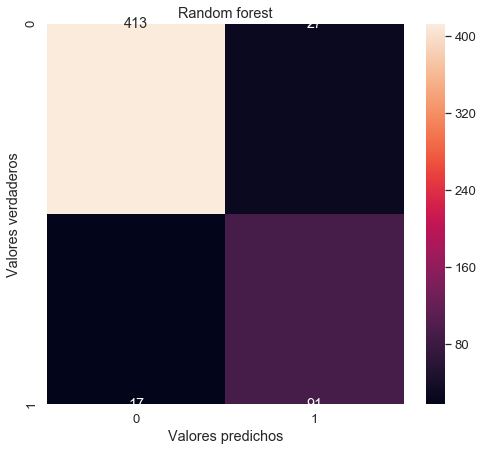

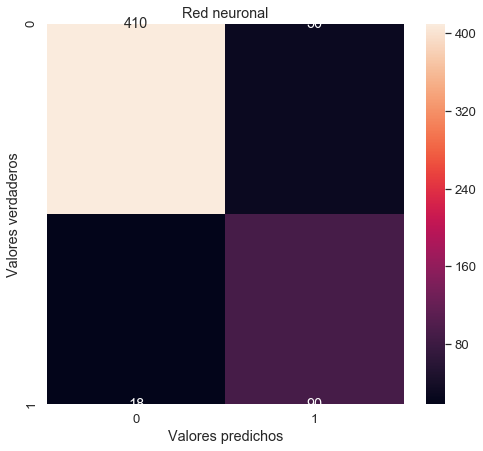

In [24]:
y_pred_MLP = MLPC.predict(X_test)
y_pred_RF = RFC.predict(X_test)

print(f'La matriz de confusion de Random Forest es para los datos en el test set: \n {confusion_matrix(y_test, y_pred_RF)}')
print(f'La matriz de confusion de la red neuronal es para los datos en el test set: \n {confusion_matrix(y_test, y_pred_MLP)}')


plt.figure(figsize=(8,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(confusion_matrix(y_test, y_pred_RF), annot=True, fmt="d") # font size
plt.title('Random forest')
plt.xlabel('Valores predichos')
plt.ylabel('Valores verdaderos')
plt.show()

plt.figure(figsize=(8,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(confusion_matrix(y_test, y_pred_MLP), annot=True, fmt="d") # font size
plt.title('Red neuronal')
plt.xlabel('Valores predichos')
plt.ylabel('Valores verdaderos')
plt.show()

Debido a que estamos analizando un sistema de pagos de crédito, los casos positivos en los que el cliente o empresa no pagó tienen una mayor importancia para los inversionistas, por lo que para este problema la exhaustividad es mas importante que la precisión. Es por eso que se decidió utilizar una beta mayor a 1 para darle mas importancia a la exhaustividad. 

In [25]:
Metrics = precision_recall_fscore_support(y_test, y_pred_RF, average='binary', beta = 1.5)

print('Para random forest')
print(f'La precision en los datos de prueba es: {Metrics[0]:0.4f}')
print(f'El recall en los datos de prueba es: {Metrics[1]:0.4f}')
print(f'El F1 en los datos de prueba es: {Metrics[2]:0.4f}')

Para random forest
La precision en los datos de prueba es: 0.7712
El recall en los datos de prueba es: 0.8426
El F1 en los datos de prueba es: 0.8193


## Conclusion

El modelo arrojó un F con un valor de 0.81, lo cual indica que el modelo utilizado tiene una alta capacidad de predecir de manera correcta si un cliente va a pagar o no el crédito que se le dió